# Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import itertools as it
import os.path as osp

import helpers_06

%matplotlib inline

D:\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# AlexNet

## Grab and Load the Pre-existing Weights

Next week, we are going to do full *transfer learning*.  But, for this week, we are going to take a different, simpler strategy.  In our model building up to this point, we've initialized the weights in our networks randomly (from a truncated normal distribution or something similar).  We're going to do much, much better today.  Instead of starting with random weights and training them, we're going to make use of weights that someone already did the hard work of training!  

So, we're going to have a two part strategy:
  1.  Create the architecture of AlexNet (that matches the weights someone else learned)
  2.  Use those learned weights to initialize our network.
  
Then, boom, we have a working AlexNet without having to train it.  If you are unimpressed, realized that the inital training of the AlexNet in the acdemic paper took about six days on a machine with two highend GPUs.  We are really saving computational work here!

Getting the weights is an exercise in frustration, so we've insulated you from that process with a helper.  Here goes:

In [3]:
pretrained_weights, readable_labels = helpers_06.fetch_alexnet_weights_and_classes()

File bvlc_alexnet.npy already present.
File caffe_classes.py already present.


## Exercise

You can use your Python-fu to investigate `pretrained_weights` and `readable_labels`.  In particular:
  1.  What type of thing is `pretrained_weights`?  
  2.  What is its structure?
  3.  If I tell you that the inner-most values come as `W,b` pairs, can you get the *shapes* of the coefficients?
  4.  What's in `readable_labels`?

### Solution

Weights are stored as a dictionary of lists, with each entry storing the trained weight and bias values.

In [18]:
print("kernal1:",pretrained_weights['conv1'][0].shape)
print("bias1:",pretrained_weights['conv1'][1].shape)
print("kernal2:",pretrained_weights['conv2'][0].shape)
print("kernal3:",pretrained_weights['conv3'][0].shape)
print("kernal4:",pretrained_weights['conv4'][0].shape)
print("kernal5:",pretrained_weights['conv5'][0].shape)
print("fc6:",pretrained_weights['fc6'][0].shape)
print("fc7:",pretrained_weights['fc7'][0].shape)
print("fc8:",pretrained_weights['fc8'][0].shape)

kernal1: (11, 11, 3, 96)
bias1: (96,)
kernal2: (5, 5, 48, 256)
kernal3: (3, 3, 256, 384)
kernal4: (3, 3, 192, 384)
kernal5: (3, 3, 192, 256)
fc6: (9216, 4096)
fc7: (4096, 4096)
fc8: (4096, 1000)


In [5]:
len(readable_labels)

1000

These values tell us the size of the network we need to create.  Fortunately, since we can use NumPy arrays (directly) to create Tensors, we don't have to copy these shapes down anywhere! 

In [6]:
tf.constant(pretrained_weights['conv1'][0])

<tf.Tensor 'Const:0' shape=(11, 11, 3, 96) dtype=float32>

## Defining Layers

##### Convolution Layers

Having the weights ahead of time is very helpful -- if we can make use of them!  We've got to do something a little bit different.  Here's an old way that we recreated a convolutional layer.  Remember that we set the weights and biases to random values and a constant, respectively.

In [7]:
def random_init_conv_layer(incoming, num_kernels, kernel_sz, 
                           strides=[1, 1], padding='SAME',
                           bval=0.01, 
                           activation_fn=tf.nn.relu, 
                           name=None):
    prev_outshape = incoming.shape.dims[-1].value
    kshape = kernel_sz + [prev_outshape, num_kernels]

    fan_in = np.prod(incoming.shape[1:]).value
    xavier_stddev = np.sqrt(2.0 / fan_in)
    
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'conv_layer'):
        w = tf.Variable(tf.truncated_normal(kshape, stddev=xavier_stddev), name='kernel')
        b = tf.Variable(tf.constant(bval, shape=[num_kernels]), name='bias')
        conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        z = tf.nn.bias_add(conv, b)
        return z if activation_fn is None else activation_fn(z)

## Exercise

Create a convolution layer that uses explictly given NumPy arrays to initialize its weights and biases.

In [ ]:
# pt stands for "pre-trained"
def pt_conv_layer(incoming, init_weight, init_bias,
                  strides=[1, 1], padding='SAME',
                  activation_fn=tf.nn.relu, 
                  name=None):
    'expects to be given numpy arrays or tensors for weight/bias'
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'conv_layer'):
        #
        # FILL ME IN
        #
        return a 

### Solution

In [8]:
# pt stands for "pre-trained"
def pt_conv_layer(incoming, init_weight, init_bias,
                  strides=[1, 1], padding='SAME',
                  activation_fn=tf.nn.relu, 
                  name=None):
    'expects to be given numpy arrays or tensors for weight/bias'
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'conv_layer'):
        #
        # FILL ME IN
        #
        w = tf.Variable(init_weight,name="weight")
        b = tf.Variable(init_bias,name="bias")
        conv = tf.nn.conv2d(incoming,w,strides,padding,name="conv")
        a = tf.nn.bias_add(conv,b)
        return a if activation_fn is None else activation_fn(a)

##### Split Convolution
To mimic the architecture of AlexNet, we can split the convolution layer.  When AlexNet was trained for real, this is the portion that got divided between two GPUs.  This isn't 100% necessary for us to use, because we are just filling in weights.  But it shows how you would do the splitting, if you ever have a need for it.

In [28]:
# pt stands for "pre-trained"
def pt_split_conv_layer(incoming, init_weight, init_bias, 
                        strides=[1, 1], padding='SAME',
                        activation_fn=tf.nn.relu, 
                        name=None):
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'split_conv_layer'):
        w = tf.Variable(init_weight, name='kernel')
        b = tf.Variable(init_bias, name='bias')
        
        if True: # ignoring the split part for now
            i_a, i_b = tf.split(incoming, 2, 3, name='split_inputs')
            w_a, w_b = tf.split(w, 2, 3, name='split_weights')

            conv_a = tf.nn.conv2d(i_a, w_a, strides, padding, name='conv_a')
            conv_b = tf.nn.conv2d(i_b, w_b, strides, padding, name='conv_b')
            merge = tf.concat([conv_a, conv_b], 3)
            
        else:
            conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
            
        z = tf.nn.bias_add(merge, b)       
        a = activation_fn(z) if activation_fn is not None else z
        return a


notes:  

>tf.split(value,num_or_size_splits,axis=0,num=None,name='split') 

example:

```python
#if the value shape is (5,30)
#the first situation:num_or_size_splits is a vector
split0, split1, split2 = tf.split(value, [4, 15, 11], 1)
tf.shape(split0)  # [5, 4]
tf.shape(split1)  # [5, 15]
tf.shape(split2)  # [5, 11]
#the second situation:num_or_size_splits is a scalar
split0, split1, split2 = tf.split(value, num_or_size_splits=3, axis=1)
tf.shape(split0)  # [5, 10]
tf.shape(split1)  # [5, 10]
tf.shape(split2)  # [5, 10]
```

>tf.concat([t1,t2],axis)

```
i_a=np.random.randn(1,27,27,48)
i_b=np.random.randn(1,27,27,48)
w_a=np.random.randn(5,5,48,128)
w_b=np.random.randn(5,5,48,128)
conv_a=tf.nn.conv2d(i_a,w_a,[1,1,1,1],'SAME')
conv_b=tf.nn.conv2d(i_b,w_b,[1,1,1,1],'SAME')
tf.concat([conv_a,conv_b],3)#tf.Tensor 'concat:0' shape=(1, 27, 27, 256) dtype=float64>

```


##### AlexNet Utility Layers

Two more layers that are useful for AlexNet.  Here, we make use of TensorFlow's built-in `relu_layer` to make a fully connected layer.  If you want to know where the magic constants in `alex_lrn_layer` come from, see:
  * http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/myalexnet_forward_newtf.py

In [29]:
# pt stands for "pre-trained"
def pt_alex_fc_layer(incoming, init_weights, init_biases, name=None):
    'expects to be given numpy arrays or tensors for weight/bias'
    with tf.name_scope('fully_connected'):
        return tf.nn.relu_layer(incoming, init_weights, init_biases, name=name)
    
def alex_lrn_layer(inputs):
    'lrn with some magic constants'
    return tf.nn.local_response_normalization(inputs, 2, 1.0, 2e-05, 0.75)

##### Pooling Layers

This is the same as last week's, with a minor convenience tweak to prepend/append `1`s to the stride for us.

In [30]:
def pool_layer(incoming, ksize, strides, padding='VALID',
                pool_fn=tf.nn.max_pool, name=None):
    # pooling layer with stride padding
    ksize = [1] + ksize + [1]
    strides = [1] + strides + [1]    
    with tf.variable_scope(name, 'pool_layer'):
        return pool_fn(incoming, ksize, strides, padding)
    

## Defining the Main AlexNet Graph

Here's the architecture of the main AlexNet component:

![](images/alexnet.png)


And, here are the layer weight sizes (say that three times fast!) that we loaded above:

    conv1: (11, 11, 3, 96)
    conv2: (5, 5, 48, 256)
    conv3: (3, 3, 256, 384)
    conv4: (3, 3, 192, 384)
    conv5: (3, 3, 192, 256)
    fc6: (9216, 4096)
    fc7: (4096, 4096)
    fc8: (4096, 1000)

## Exercise

Try to put the architecture and the sizes together to make your own AlexNet.  If you can do it wihtout the following hints, you are a rockstart.
  1.  The layer structure is (note, lrn and pool don't have weights):
    *  conv, lrn, pool
    *  split, lrn, pool
    *  conv, split, split, pool, flat
    *  full, full, and a special fully connected: `tf.nn.xw_plus_b`.
  2.  The size and strides for the pool layers are `[3,3]` and `[2,2]` respectively.
  3.  You can find the stride for the first conv in the diagram.
  4.  If you are very stubborn and don't want to look at the solution, see here for more hints:
    *   * http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/myalexnet_forward_newtf.py

In [31]:
def alexnet(images, init_weights):
    #
    # FILL ME IN
    #
    pass

### Solution

In [32]:
def alexnet(images, init_weights,debug=False):
    with tf.name_scope('alexnet'):
        print('images:',images.shape.as_list())
        
        conv_1 = pt_conv_layer(images,init_weights['conv1'][0],init_weights['conv1'][1],strides=[4,4],padding='VALID',name='conv_1')
        lrn_1 = alex_lrn_layer(conv_1)
        pool_1 = pool_layer(lrn_1,ksize=[3,3],strides=[2,2],name='pool_1')
        if debug:
            print('conv1:',conv_1.shape.as_list())
            print('lrn1:',lrn_1.shape.as_list())
            print('pool1:',pool_1.shape.as_list())
        
        conv_2 = pt_split_conv_layer(pool_1,*init_weights['conv2'],name='conv_2')
        lrn_2 = alex_lrn_layer(conv_2)
        pool_2 = pool_layer(lrn_2,[3,3],[2,2],name='pool_2')
        if debug:
            print('conv2:',conv_2.shape.as_list())
            print('lrn2:',lrn_2.shape.as_list())
            print('pool2:',pool_2.shape.as_list())
        
        conv_3 = pt_conv_layer(pool_2,*init_weights['conv3'],name='conv_3')
        conv_4 = pt_split_conv_layer(conv_3,*init_weights['conv4'],name='conv_4')
        conv_5 = pt_split_conv_layer(conv_4,*init_weights['conv5'],name='conv_5')
        pool_5 = pool_layer(conv_5,[3,3],[2,2],name='pool_5')
        flat = helpers_06.flatten(pool_5)
        if debug:
            print('conv_3:',conv_3.shape.as_list())
            print('conv_4:',conv_4.shape.as_list())
            print('conv_5:',conv_5.shape.as_list())
            print('pool_5:',pool_5.shape.as_list())
            print('flat:',flat.shape.as_list())
            
        fc6 = pt_alex_fc_layer(flat,*init_weights['fc6'],name='fc6')
        fc7 = pt_alex_fc_layer(fc6,*init_weights['fc7'],name='fc7')
        fc8 = tf.nn.xw_plus_b(fc7,*init_weights['fc8'],name='fc8')
        if debug:
            print('fc6:',fc6.shape.as_list())
            print('fc7:',fc7.shape.as_list())
            print('fc8:',fc8.shape.as_list())
    return fc8

## The "Loaded Weights" AlexNet Model

We've now got all the pieces we need to make use of an AlexNet model made from previously learned (and shared with us) weights.  We'll sneak one other piece into our `class`:

    def save(s):
        with s.graph.as_default():
            tf.train.Saver().save(s.session, osp.join(_dir, "alexnet"))

This will let us do: `mm.save('saved_models')` to save our model.

In [33]:
class AlexNet_Model:
    def __init__(s, img_height, img_width, init_weights):  # non-standard, for abbreviation
        s.graph = tf.Graph()
        with s.graph.as_default():
            with tf.name_scope('inputs'):
                # consider two possibilities here:
                # 1.  use a fixed image size [img_height x img_width]
                # s.images = tf.placeholder(tf.float32, 
                #                           shape=[None, img_height, img_width, 3], name="images")
                # 2.  use variable image sizes -and- rescale the images to the same size
                #     in a rescaling step (see name_scope('rescale')) ... note, one "batch"
                #     of images must all be the same size of image
                s.images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name="images")

                # note, we don't need labels, b/c the work is already done for us (no fitting/training)
                
            with tf.name_scope('rescale'):
                s.scaled_images = tf.image.resize_images(s.images, [img_height, img_width])
                

            s.logits = alexnet(s.scaled_images, init_weights, debug=True)
                        
            with tf.name_scope('prediction'):
                s.softmax    = tf.nn.softmax(s.logits, name="softmax")
                s.prediction = tf.cast(tf.argmax(s.softmax, 1), tf.int32) # FIXME: unnecessary cast?

            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=s.graph)
        s.session.run(s.init)

    def save(s, _dir):
        # fixme:  save(session) versus export_meta_graph
        helpers_06.mkdir(_dir)
        with s.graph.as_default():
            tf.train.Saver().save(s.session, osp.join(_dir, "alexnet"))
        
        
    def predict(s, test_dict):
        pred, prob = s.session.run([s.prediction, s.softmax], feed_dict=test_dict)
        return pred, prob

## Train our AlexNet

In [34]:
# from above:
# pretrained_weights, readable_labels = helpers_06.fetch_alexnet_weights_and_classes()
mm = AlexNet_Model(227, 227, init_weights=pretrained_weights)

images: [None, 227, 227, 3]
conv1: [None, 55, 55, 96]
lrn1: [None, 55, 55, 96]
pool1: [None, 27, 27, 96]
conv2: [None, 27, 27, 256]
lrn2: [None, 27, 27, 256]
pool2: [None, 13, 13, 256]
conv_3: [None, 13, 13, 384]
conv_4: [None, 13, 13, 384]
conv_5: [None, 13, 13, 256]
pool_5: [None, 6, 6, 256]
flat: [None, 9216]
fc6: [None, 4096]
fc7: [None, 4096]
fc8: [None, 1000]


## Test our AlexNet

##### Grab Some Test Images

In [35]:
img_names = ['dog', 'laska', 'poodle']
base_url = "http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/"
local_dir = "data/alexnet/"

for img_name in img_names:
    helpers_06.maybe_download("{}.png".format(img_name), base_url, local_dir)

Download complete for dog.png
Download complete for laska.png
Download complete for poodle.png


(227, 227, 3)

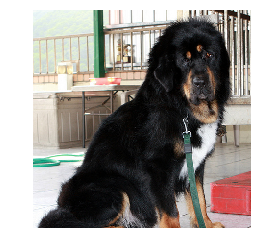

In [64]:
from scipy.misc import imread
import os.path as osp
import imageio
img = imageio.imread(osp.join(local_dir, 'dog.png'))[:,:,:3]
plt.imshow(img)
plt.axis('off');
img.shape

## Exercise

Use our reconstituted model to label this nice dog.  You'll need two things to do it:
  1.  We wanted indices into the labels (`readable_labels` from way above).  With the output `probs`, `top5_indices = np.argsort(probs, 1)[0][-5:]`.
  2.  With only one image, we have to fake a batch.  Do this: `img_batch = np.expand_dims(img, 0)`.  Then, you can use `img_batch` as if it were multiple images.

### Solution

In [70]:

img=img.reshape(1,227,227,3)

test_dict={mm.images:img}
pred,prob=mm.predict(test_dict)
print(pred,readable_labels[pred[0]])
top5_indices = np.argsort(prob,1)[0][-5:]
print(np.array(readable_labels)[top5_indices])

[205] flat-coated retriever
['standard poodle' 'Labrador retriever' 'Tibetan mastiff'
 'Newfoundland, Newfoundland dog' 'flat-coated retriever']


# Save our Model

In [71]:
mm.save('saved_models')

# Load our Model

And here is how we can bring that saved model back.  We'll play with a "reloaded" model more next week

In [72]:
# create a placeholder graph to "rehydrate" our freeze-dried AlexNet
old_alex_graph = tf.Graph()
with old_alex_graph.as_default():
    # importing the graph will populate new_alex_graph
    saver = tf.train.import_meta_graph("saved_models/alexnet.meta")

# Practice with Optimizers

To get some practice with optimizers, go back to one of your MNIST (or CIFAR) models.  The Optimizers are listed here:
  * https://www.tensorflow.org/api_guides/python/train

Experiment with using several different optimizers and see:
  1.  learning performance
  2.  convergance rate
  3.  processing time (per step/epoch).